<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_13_kernel_density_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kernel density estimation / Ядрова оцінка густини розподілу

**K**ernel **D**ensity **E**stimation (KDE) is a technique for estimation of probability distribution of the random variable.
Before we had two instruments for that:
* histograms to capture emphirical frequencies to approximate underlying probability distribution;
* guessing a family of probability distributions that the data probably follows and estimating parameters (using MLE) of a most fit of these distributions.

KDE is another option for us. It can be seen as an extention of the histogram technique.

#Motivating KDE: Histograms

Although histograms are useful and widely used it's also true that

$$
\text{Histograms are trickier than they seem.}
$$

The bins sizes and location could be chosen in many ways. This can drastically change the overall shape of the histogram.

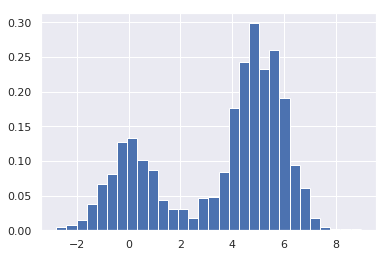

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_data(N, f=0.3, rseed=1):
  rand = np.random.RandomState(rseed)
  x = rand.randn(N)
  x[int(f * N):] += 5
  return x

x = make_data(1000)
hist = plt.hist(x, bins=30, density=True)

In [0]:
# histogram is normed = area equa to 1
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

The issue is that depending on the bins the histograms may have different *qualitive* features. Consider this.

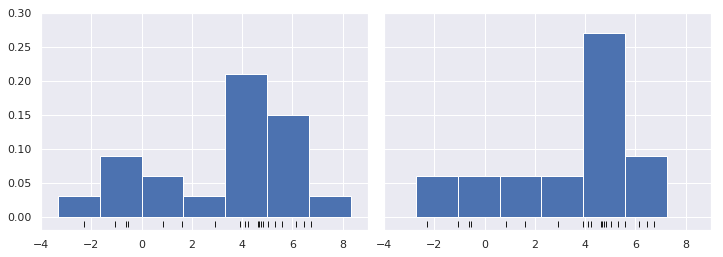

In [0]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
  ax[i].hist(x, bins=bins + offset, density=True)
  ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
  


So it the underlying distribution bimodal or unimodal?

---

**Sidenote** 

---

On the above picture we have used **a rug plot** -- a plot of data for a single quantitative variable, displayed as marks along an axis. As such it is analogous to a histogram with zero-width bins, or a one-dimensional scatter plot.
Rug plots are often used in combination with two-dimensional scatter plots by placing a rug plot of the x values of the data along the x-axis, and similarly for the y values. This is the origin of the term "rug plot", as these rug plots with perpendicular markers look like tassels along the edges of the rectangular "rug" of the scatter plot.

---

We can try to solve the problem with the ambiguity of the bin choice by the following idea.
You can rethink histogram as square blocks stacked on each other. Each block represents one point of data. If several datapoints are contained within one bin their blocks are placed one at the top of the other.

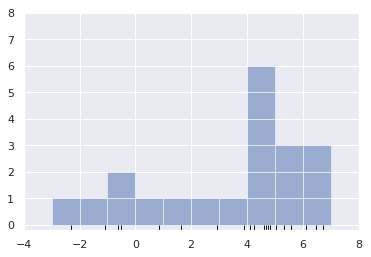

In [0]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
  for i in range(count):
    ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

But what if we placed each block so its center is just below the point it represents.

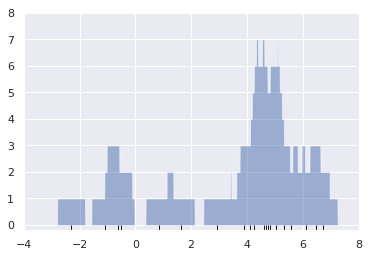

In [0]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

Analytically this can be seen as if we have placed a "square" function (kernel) centered at each point and then we have summed all the functions up.

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/tophat.png) 

<br>

This type of kernel is called top hat as it recalls a flat-crowned hat (aka cylinder - another term that is both a hat and a math object). The length of the kernel function has not have to be equal to the height.

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/hat.png) 

<br>

Now to make things not so "right angled" we can sum up smooth functions (for example Gaussians) instead of rectangular shapes (top hats).

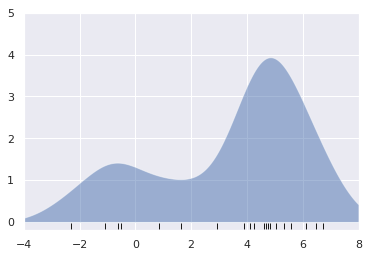

In [0]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

# a Gaussian kernel

#Kernel Density Estimation 

In order to do KDE we need to make our mind about two things:
  * kernel, which specifies the shape of the distribution placed at each point
  * kernel bandwidth, which controls the size of the kernel at each point


##Choosing kernel

On every data point $x_i$ we place a *kernel* function $K$. The kernel density estimate is then

$$
\hat{f}_h(x)=\frac{1}{Nh}\sum_{i=1}^N K\left(\frac{x-x_i}{h}\right),
$$

where $h$ is the scaling parameter caled *bandwidth*.

In fact we can subtitute equal factors of $1/N$ with weights that can emphasize one points against the others:

$$
\begin{aligned}
& \hat{f}_h(x)=\frac{1}{h}\sum_{i=1}^N w_i \cdot K\left(\frac{x-x_i}{h}\right), \\
&\sum_{i=1}^N w_i=1.
\end{aligned}
$$

The kernel function is typically
* non-negative: $K(x) \geq 0$;
* symmetric: $\,\,\,\,\, K(x)=K(-x)$;
* decreasing: $\,\,\,\, K'(x)\leq 0$;
* $\int K(x)dx=1$.

$K$ has either compact support or decrease sufficiently fast approaching infinity.

In the multivariate case (with $d$ dimensions) we have

$$
\hat{f}_h(x)=\frac{1}{Nh^d}\sum_{i=1}^N K\left(\frac{\|x-x_i\|}{h}\right),
$$

where $\|\cdot \|$ is a some kind of norm, for example $p$-norm

$$ 
\|x\|_p = \left(\sum_i |x_i|^p \right)^{1/p}
$$

Although it's fun to see how the choise of kernel and metric affects the outcome,  it doesn't matter so much when there are lots of points.

Nonetheless, what are our options when choosing the kernels?

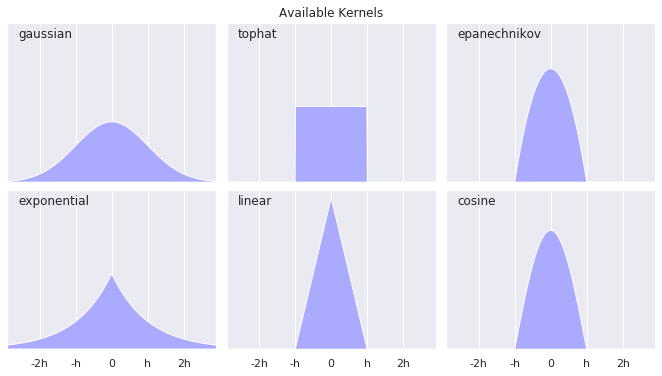

In [0]:
#@title Available kernels

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels');


$$
\begin{aligned}
& K_{\text{Gausian}}(x;h) && \propto \quad e^{-\frac{x^2}{2h^2}}; \\
& K_{\text{Tophat}}(x;h) && \propto \quad 1, &&& \text{if   } \quad x<h; \\
& K_{\text{Epanechnikov}}(x;h) && \propto \quad 1-\frac{x^2}{h^2}; \\
& K_{\text{Exponential}}(x;h) && \propto \quad e^{-\frac{x}{h}}; \\
& K_{\text{Linear}}(x;h) && \propto \quad 1-\frac{|x|}{h}, &&& \text{if   } \quad |x|<h; \\
& K_{\text{Cosine}}(x;h) && \propto \quad \cos{\frac{\pi x}{2 h}}, &&& \text{if   } \quad x<h. \\
\end{aligned}
$$

you can choose those by setting `kernel` parameter:
* `kernel = 'gaussian';`
* `kernel = 'tophat';`
* `kernel = 'epanechnikov';`
* `kernel = 'exponential';`
* `kernel = 'linear';`
* `kernel = 'cosine'.`

##Choosing bandwidth

The choice of bandwidth within KDE is extremely important (the bias–variance trade-off).

   *  too narrow a bandwidth leads to a high-variance estimate (i.e., overfitting)
   * too wide a bandwidth leads to a high-bias estimate (i.e., underfitting)

<br>

   ![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/band.png) 

###Theoretical considerations

The most common optimality criterion used to select this parameter is the expected $L_2$ risk function, also termed the **mean integrated squared error**:

$$\text{MISE}(h)=\mathbb{E}\left[\int \left(\hat{f}_h(x)-f(x)\right)^2 dx \right].$$

Under weak assumptions on $f$ and $K$

$$
\text{MISE}(h)=\text{AMISE}(h)+o\left(\frac{1}{Nh}+h^4\right).
$$

The $\text{AMISE}$ is the **A**symptotic **MISE** which consists of the two leading terms

$$
\text{AMISE}(h)=\frac{R(K)}{Nh}+\frac{1}{4}m_2(K)^2h^4R(f''),
$$

where $R(g)=\int g(x)^2 dx$ and $m_2(K)=\int x^2 K(x) dx$. Thus
* $R(g)$ is the functional $L_2$-norm;
* $m_2(K)=\mathbb{E}_K[x^2]$ is the so-called $2$-nd non-central moment of the kernel.

The minimum of this $\text{AMISE}$ is the solution to this differential equation

$$
\begin{aligned}
& \frac{\partial}{\partial h}\text{AMISE}(h) =-\frac{R(K)}{N h^2}+m_2(K)^2h^3R(f'')=0 \color{red}{\Rightarrow} \\
& \color{red}{\Rightarrow} \qquad h_{\text{AMISE}} =\frac{R(K)^{1/5}}{m_2(K)^{2/5} R(f'')^{1/5}N^{1/5}}.
\end{aligned}
$$

Neither the $\text{AMISE}$ nor the $h_\text{AMISE}$ formulas are able to be used directly since they involve the unknown density function $f$ or its second derivative $f''$, so a variety of automatic, data-based methods have been developed for selecting the bandwidth.

###Silverman's Rule of Thumb

If the data is unimodal and close to normal, silverman’s rule of thumb may be used. It’s computationally very fast, but derived by assuming that the true density is normal. This is somewhat paradoxal, since if we knew that the data was truly normal it would render a kernel density estimator unnecessary.

$$
h=\left(\frac{4}{3}\frac{\hat{\sigma}^5}{N}\right)^{\frac{1}{5}}.
$$

###Improved Sheather-Jones (ISJ) algorithm 

If much data is available and the data is far from normal or multimodal, the **I**mproved **S**heather **J**ones (ISJ) algorithm may be used. The Improved Sheather-Jones algorithm is a plug-in selector. 

The ISJ algorithm attempts to find h to minimize the asymptotic mean integrated square error ($\text{AMISE}$), which depends on the unknown quantity $\|f''(x)\|^2$. Using a recursive formula, this is accomplished by computing a sequence of estimates.

###Selecting the bandwidth via cross-validation

In [0]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split

bandwidths = 10 ** np.linspace(-1, 1, 100)
loo = LeaveOneOut()
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=loo)
grid.fit(x[:, None]);
grid.best_params_

{'bandwidth': 1.1233240329780276}

#How to use

(-0.02, 0.22)

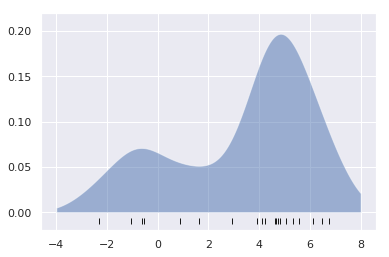

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

# KDE as Mixture Model

We see that KDE reminds MM taken to the extreme: the number of components we throw into the mix equals the number of points.

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/mix.png) 

<br>

If the number of point is huge the "shot noise" from the individual points becomes negligible and the overall underlying distibution hopefully emerges.

#Gaussian blur

We have seen that histograms may be misleading. Also they are "grainy" as they discretize (sample) continuous data. Pdf estimate could be kept smooth by using gaussian KDE.

Idea similar to gaussian KDE is involved in Gaussian smoothing of images.
In image processing, a Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise and reduce detail. A Gaussian blur effect is typically generated by convolving an image with a kernel of Gaussian values. 

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/blur.png) 

<br>

Let's first sample image (keeping $1$ pixel out of $10$ along each dimension). What we get is an analog of a histogram. If we perform a Gaussian blur afterwards we regain some of the smootheness.

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/lena_1.png) 

<br>

#Example: KDE on a Sphere

Perhaps the most common use of KDE is in graphically representing distributions of points. For example, in the `Seaborn visualization library` KDE is built in and automatically used to help visualize points in one and two dimensions.
Here we will look at a slightly more sophisticated use of KDE for visualization of distributions. We will make use of some geographic data that can be loaded with `ScikitLearn`: the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the brown-throated sloth) and *Microryzomys minutus* (the forest small rice rat).

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/anim.png) 



In [0]:
import numpy as np

!sudo apt-get install libgeos-dev > /dev/null
!sudo pip3 install -U git+https://github.com/matplotlib/basemap.git > /dev/null
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions();
# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-dy6g376t


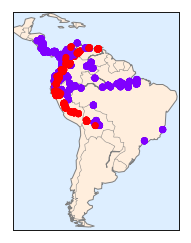

In [0]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids
xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
m = Basemap(projection='cyl', resolution='c', llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(), llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, c=species, cmap='rainbow', latlon=True);

Unfortunately, this doesn’t give a very good idea of the density of the species, because points in the species range may overlap one another. You may not realize it by looking at this plot, but there are over $1600$ points shown here!
Let’s use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map. Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the haversine distance metric, which will correctly represent distances on a curved surface.

**Note**:
The *haversine formula* determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

$$
d=2r\arcsin{\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos{\phi_1}\cdot \cos{\phi_2}\cdot \sin^2\left(\frac{\lambda_2-\lambda_1}{2} \right)}},
$$

where 
* $d$ is the distance between the two points along a great circle of the sphere;
* $\phi$ -- latitude of point;
* $\lambda$ -- longitude of point.

The term haversine  is due to haversine $\text{hav}$ function that was used instead of $\sin$ in the formula.

$$
\text{hav}(x)=\sin^2\left(\frac{x}{2}\right).
$$

So if we rewrite the formula above using haversine it will read

$$
\text{hav}(\Theta)=\text{hav}(\phi_2-\phi_1)+\cos{\phi_1} \cdot \cos{\phi_2} \cdot \text{hav}(\lambda_2-\lambda_1),
$$

with $\Theta=\frac{d}{r}$ is central angle between any two points on a sphere.

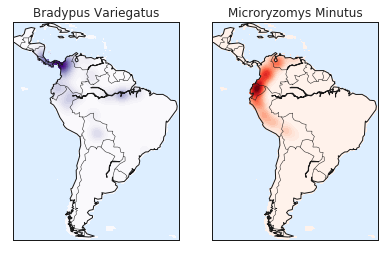

In [0]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
  axi.set_title(species_names[i])

  # plot coastlines with Basemap
  m = Basemap(projection='cyl', llcrnrlat=Y.min(), urcrnrlat=Y.max(), llcrnrlon=X.min(), urcrnrlon=X.max(), resolution='c', ax=axi)
  m.drawmapboundary(fill_color='#DDEEFF')
  m.drawcoastlines()
  m.drawcountries()
  
  # construct a spherical kernel density estimate of the distribution
  kde = KernelDensity(bandwidth=0.03, metric='haversine')
  kde.fit(np.radians(latlon[species == i]))

  # evaluate only on the land: -9999 indicates ocean
  Z = np.full(land_mask.shape[0], -9999.0)
  Z[land_mask] = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)
  
  # plot contours of the density
  levels = np.linspace(0, Z.max(), 25)
  axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])  

Now we have a much clearer picture of the geographical distribution of observation of two species.



#Example: Fisher irisis

Here is another example of nice visualization.

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/iris.png) 

Text(3.8, 4.5, 'setosa')

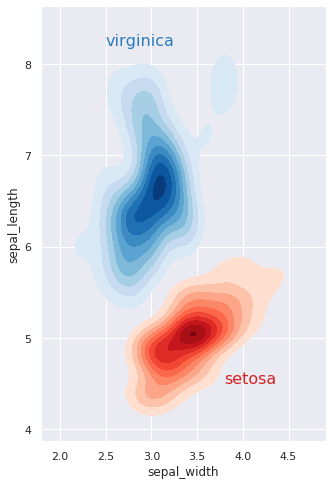

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

setosa = iris.query("species == 'setosa'")
virginica = iris.query("species == 'virginica'")

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue)
ax.text(3.8, 4.5, "setosa", size=16, color=red)

#Example: Not-So-Naive Bayes

For naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the “naive” element and perform the same classification with a more sophisticated generative model for each class.
It’s still Bayesian classification, but it’s no longer naive.

1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data.
This allows you for any observation x and label y to compute a likelihood $P(x|y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$ .
4. For an unknown point x , the posterior probability for each class is $P(y|x)= P(x|y)P(y)$. The class that maximizes this posterior is the label assigned to the point.

Let’s try this custom estimator on a problem we have seen before: the classification of handwritten digits. Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the `GridSearchCV` meta-estimator.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

# BaseEstimator contains the logic necessary to clone/copy an estimator for use in a crossvalidation procedure
# ClassifierMixin defines a default score() method used by such routines
class KDEClassifier(BaseEstimator, ClassifierMixin):
  """Bayesian generative classification based on KDE
  Parameters
  ----------
  bandwidth : float
  the kernel bandwidth within each class
  kernel : str
  the kernel name, passed to KernelDensity
  """
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
  
  # find the unique classes in the training data, 
  # train a KernelDensity model for each class, 
  # compute the class priors based on the number of input samples.
  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
    return self # for chaining
  
  # predicting labels on new data
  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X) for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
  
  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

We now use this class.

In [0]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, cv=3)
grid.fit(digits.data, digits.target)
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


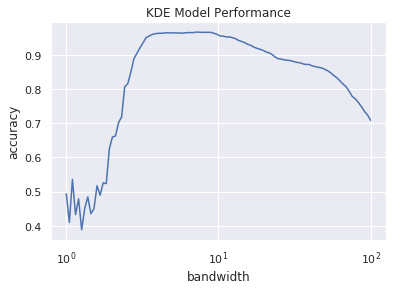

In [0]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over $96\%$; this is compared to around $80\%$ for the naive Bayesian classification:


In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target, cv=3).mean()

0.8186003803550138

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to! If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.
If you would like to take this further, there are some improvements that could be made to our KDE classifier model:
* We could allow the bandwidth in each class to vary independently.
*  We could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e., use the scores from KernelDensity itself rather than the global prediction accuracy).

#Interactive KDE

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(kernel='gaussian')

def fit_distribution(X, bandwidth):
  params = {'bandwidth': bandwidth}
  kde.set_params(**params)
  kde.fit(X)

def evaluate_distribution(X):
  logprob = kde.score_samples(X)
  return np.exp(logprob)

In [2]:
#@title Interactive KDE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
        
def plot_clusters(x_, y_, z_):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax = sns.kdeplot(X[:,0], X[:,1], cmap="Blues", shade=True, shade_lowest=False)
  sns.set()
  ax.contourf(x_, y_, z_, alpha=0.5, cmap="Blues")
  ax.tick_params(axis="y",direction="in", pad=-60)
  ax.tick_params(axis="x",direction="in", pad=-30)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])


  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64



import json
from IPython.display import display, clear_output

def invoke(pts, n):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  fit_distribution(X, float(n)/1000.0)
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
  G  = evaluate_distribution(x_vec).reshape((x_.shape[0],y_.shape[0]))
  figr = plot_clusters(x_, y_, G)
  image_base64 = figure_to_base64(figr)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X)})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(255, 128, 0, 0.5)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: 'pdf estimate',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Bandwidth x 1000:<br>
    <input type="range" min="1" max="200" value="100" oninput="h_change(this.value)">
    <br><div id="slider_val">100</div>
   <br><br>
    <button type="button" onclick="calculate();">
      KDE
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

In [14]:

import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(255, 128, 0, 0.5)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

   var delta = 10;
   function test(d)
   {
     delta = d;
   }

   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: 'pdf estimate',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          },
          sliders: [{
            pad: {t: 30},
            currentvalue: {
              xanchor: 'right',
              prefix: 'color: ',
              font: {
                color: '#888',
                size: 20
              }
            },
            steps: [{
              label: 'red',
              method: 'restyle',
              args: ['line.color', 'red']
            }, {
              label: 'green',
              method: 'restyle',
              args: ['line.color', 'green']
            }, {
              label: 'blue',
              method: 'test',
              args: [0]
            }]
          }]
        };
     Plotly.newPlot(cell_for_plot, data, layout);
     cell_for_plot.on('plotly.restyle', (x, y) => {delta = 0;});
   }

   function plot_scatter(s_x, s_y, s_z)
   {
     s_z = s_z.map(n => n + delta);
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Bandwidth x 1000:<br>
    <input type="range" min="1" max="200" value="100" oninput="h_change(this.value)">
    <br><div id="slider_val">100</div>
   <br><br>
    <button type="button" onclick="calculate();">
      KDE
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

In [53]:
from google.colab import widgets
import ipywidgets

params = [];

def plot_pdf(plot_separate):
  global params
  if not params:
    return

  pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3 = params
  x = np.linspace(0, 100, 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    if plot_separate:
      plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))
  
  plt.plot(x, P_sum, 'k', linewidth=3.0, label="mixture")
  plt.title('Mixture of 3 gaussians')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.show()

def set_and_plot(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  global params
  params = [pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3]
  plot_pdf(True)

def ker_plot(b_w, k_t):
  print(b_w, k_t)
  plot_pdf(False)

tb = widgets.TabBar(['mix distribution', 'find kernel'], location='top')
with tb.output_to(0):
  words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
  mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
  maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
  vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
  sliders = [ipywidgets.FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
  pi_slider = ipywidgets.FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
  boxes = [VBox([pi_slider])]
  for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
    boxes.append(VBox([slider1, slider2]))
  out = ipywidgets.interactive_output(set_and_plot, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})
  display(HBox(boxes), out)
with tb.output_to(1):
  ker_type = Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Kernel:',
    disabled=False)
  b_w = ipywidgets.FloatSlider(description='band width', min=0.1, max=10.0, value=1.0)
  out = ipywidgets.interactive_output(ker_plot, {"b_w": b_w, "k_t": ker_type})
  display(HBox([ker_type, b_w]), out)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>